# import library

In [69]:
import matplotlib.pyplot as plt
from skimage.filters import threshold_minimum, threshold_mean, rank, gaussian, sobel
from skimage.feature import canny
from skimage.color.adapt_rgb import adapt_rgb, each_channel, hsv_value
from skimage.morphology import rectangle
from skimage import measure
import numpy as np
import cv2

# load image

In [70]:
# image = cv2.imread(r"img\3.9k\IMG_0525.JPG")
# image = cv2.imread(r"img\10k\IMG_0581.JPG")
# image = cv2.imread(r"res.jpg")
image = cv2.imread(r"img\56k\IMG_0550.JPG")

# Step 1: Crop Resister

## Binomal histrogram / threshold segmentation

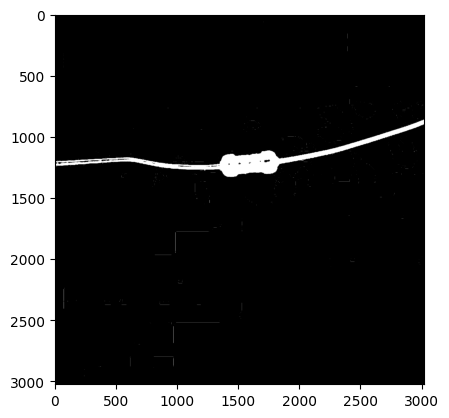

In [71]:
image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Binomal histrogram / threshold segmentation
image_mean = threshold_mean(image_gray)
image_bi = image_gray < image_mean
image_bi = image_bi.astype(np.uint8) * 255

plt.imshow(image_bi, cmap="gray")
plt.show()

## Erosion

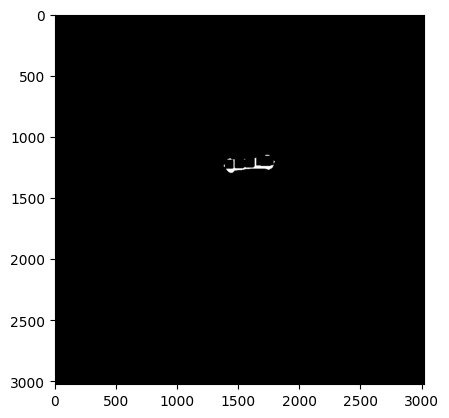

In [72]:
# Erosion
kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(5,5))
image_mor = cv2.erode(image_bi, kernel, iterations = 15)
plt.imshow(image_mor, cmap="gray")
plt.show()

## find boarder of resistor

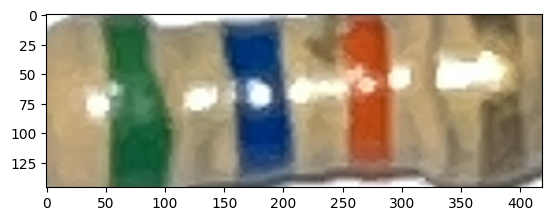

In [73]:
# find image boarder
xStart, xEnd, yStart, yEnd = image_mor.shape[0],0,image_mor.shape[1],0

for r in range(image_mor.shape[0]):
    for c in range(image_mor.shape[1]):
        if image_mor[r][c]:
            if xStart > r:
                xStart = r
            
            if yStart > c:
                yStart = c
            
            if r > xEnd: xEnd = r
            if c > yEnd: yEnd = c

image_crop = image[xStart:xEnd, yStart: yEnd]

plt.imshow(image_crop[:,:,::-1], cmap="gray")
plt.show()

# Step 2: Extract the color

## Seperate 2 areas that have no reflected light

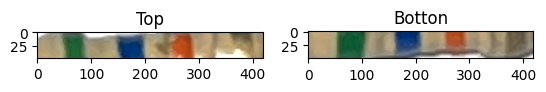

In [74]:
image_gray = cv2.cvtColor(image_crop.astype(image.dtype), cv2.COLOR_BGR2GRAY)

# quartile seperation
yQ1 = image_gray.shape[0] // 3 * 1 # top
yQ2 = image_gray.shape[0] // 3 * 2  # bottom

imageTopCrop = image_crop[:yQ1,:]
imageBottomCrop = image_crop[yQ2:,:]

plt.subplot(121)
plt.imshow(imageTopCrop[:,:,::-1])
plt.title("Top")

plt.subplot(122)
plt.imshow(imageBottomCrop[:,:,::-1])
plt.title("Botton")

plt.show()

## Binomal histrogram / threshold segmentation

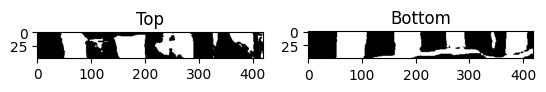

In [75]:
# Binomal histrogram / threshold segmentation
imageTopGray = cv2.cvtColor(imageTopCrop, cv2.COLOR_BGR2GRAY)
imageTopMean = threshold_mean(imageTopGray)
imageTopBi = imageTopGray < imageTopMean
imageTopBi = imageTopBi.astype(np.uint8) * 255

imageBottonGray = cv2.cvtColor(imageBottomCrop, cv2.COLOR_BGR2GRAY)
imageBottonMean = threshold_mean(imageBottonGray)
imageBottomBi = imageBottonGray < imageBottonMean
imageBottomBi = imageBottomBi.astype(np.uint8) * 255

plt.subplot(121)
plt.imshow(imageTopBi, cmap="gray")
plt.title("Top")

plt.subplot(122)
plt.imshow(imageBottomBi, cmap="gray")
plt.title("Bottom")

plt.show()

## Erosion

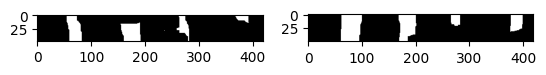

In [76]:
# Erosion
kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(5,5))
imageTopMor = cv2.erode(imageTopBi, kernel, iterations = 4)

# Erosion
kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(5,5))
imageBottomMor = cv2.erode(imageBottomBi, kernel, iterations = 4)

plt.subplot(121)
plt.imshow(imageTopMor, cmap="gray")

plt.subplot(122)
plt.imshow(imageBottomMor, cmap="gray")

plt.show()